In [42]:
from enum import Enum
from termcolor import colored
import os, pathlib, shutil, random

from matplotlib import pyplot as plt
import numpy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


In [2]:
batch_size = 32
hidden_dim=16
max_tokens=20000

In [3]:
class IMDB_REVIEWING_ANALYSIS_WORD_AS_SET:
    
    def __init__(self, text_vectorization):
        self.load_datasets()
        self.build_validation_directory_and_fill_it()
        self.text_vectorization = text_vectorization
        self.prepaire_datasets()
        self.model = self.build_model()

    def load_datasets(self):
        if not os.path.exists('aclImdb'):
            !curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
            !tar -xf aclImdb_v1.tar.gz
            !rm -r aclImdb/train/unsup
    
    def build_validation_directory_and_fill_it(self):
        base_dir = pathlib.Path("aclImdb")
        val_dir = base_dir / "val"
        train_dir = base_dir / "train"

        for category in ("neg", "pos"):

            path = val_dir / category
            if not os.path.exists(path):
                os.makedirs(path)

            files = os.listdir(train_dir / category)
            random.Random(1337).shuffle(files)
            num_val_samples = int(0.2 * len(files))
            val_files = files[-num_val_samples:]

            for fname in val_files:
                shutil.move
                (
                    train_dir / category / fname,
                    val_dir / category / fname
                )
        
    def prepaire_datasets(self):
        train_ds = keras.preprocessing.text_dataset_from_directory(
            "aclImdb/train", batch_size=batch_size
        )
        val_ds = keras.preprocessing.text_dataset_from_directory(
            "aclImdb/val", batch_size=batch_size
        )
        test_ds = keras.preprocessing.text_dataset_from_directory(
            "aclImdb/test", batch_size=batch_size
        )
        
        self.text_only_train_ds = train_ds.map(lambda x, y: x)
        self.text_vectorization.adapt(self.text_only_train_ds)
        
        self.prepaired_train_ds = train_ds.map(lambda x, y: (self.text_vectorization(x), y))
        self.prepaired_val_ds = val_ds.map(lambda x, y: (self.text_vectorization(x), y))
        self.prepaired_test_ds = test_ds.map(lambda x, y: (self.text_vectorization(x), y))
    
    def build_model(self):
        inputs = keras.Input(shape=(max_tokens,))

        x = layers.Dense(hidden_dim, activation="relu")(inputs)

        x = layers.Dropout(0.5)(x)

        outputs = layers.Dense(1, activation="sigmoid")(x)

        model = keras.Model(inputs, outputs)

        model.compile(optimizer="rmsprop",
                      loss="binary_crossentropy",
                      metrics=["accuracy"])

        return model
    
    def set_callbacks(self, callbacks):
        self.callbacks = callbacks
    
    def train_model(self, epochs):
        self.history = self.model.fit(
            self.prepaired_train_ds.cache(),
            validation_data= self.prepaired_val_ds.cache(),
            epochs=epochs,
            callbacks=self.callbacks)
    
    def plot_training_curve(self):
        plt.plot(self.history.history['accuracy'])
        plt.plot(self.history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
    
    def load_model(self, model_name):
        pass
    
    def save_training_curve(self, name):
        pass
    
    def get_test_accuracy(self):
        print(f"Test acc: {self.model.evaluate(self.prepaired_test_ds)[1]:.3f}")
    
    def forward(self, text: str):
        inputs = keras.Input(shape=(1,), dtype="string")
        processed_inputs = self.text_vectorization(inputs)
        outputs = self.model(processed_inputs)
        inference_model = keras.Model(inputs, outputs)

        prepaired_text =  tf.convert_to_tensor([[text],])
        #input_vector = self.text_vectorization(raw_text_data)
        return inference_model(prepaired_text)

In [4]:
class Text_Vectorization(Enum):
    def unigram_binary():
        return TextVectorization(
            max_tokens=max_tokens,
            output_mode="binary"
        )
    def bigram_binary():
        return TextVectorization(
            ngrams=2,
            max_tokens=max_tokens,
            output_mode="binary"
        )
    def bigram_count():
        return TextVectorization(
            ngrams=2,
            max_tokens=max_tokens,
            output_mode="count"
        )
    
    def tfidf(term, document, dataset):
        
        term_freq = document.count(term)
        doc_freq = math.log(sum(doc.count(term) for doc in dataset) + 1)
        return term_freq / doc_freq

    def tf_idf():
        return TextVectorization(
            ngrams=2,
            max_tokens=max_tokens,
            output_mode="tf-idf",
        )

In [5]:
unigram_binary_model = IMDB_REVIEWING_ANALYSIS_WORD_AS_SET(Text_Vectorization.unigram_binary())
bigram_binary_model = IMDB_REVIEWING_ANALYSIS_WORD_AS_SET(Text_Vectorization.bigram_binary())
bigram_count_model = IMDB_REVIEWING_ANALYSIS_WORD_AS_SET(Text_Vectorization.bigram_count())
tf_idf_model = IMDB_REVIEWING_ANALYSIS_WORD_AS_SET(Text_Vectorization.tf_idf())


Found 25000 files belonging to 2 classes.
Found 9000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.
Found 9000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.
Found 9000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.
Found 9000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [6]:
unigram_binary_model_callbacks = [keras.callbacks.ModelCheckpoint("unigram_binary_model.keras", save_best_only=True ) ]
unigram_binary_model.set_callbacks(unigram_binary_model_callbacks)

bigram_binary_model_callbacks = [keras.callbacks.ModelCheckpoint("bigram_binary_model.keras", save_best_only=True ) ]
bigram_binary_model.set_callbacks(bigram_binary_model_callbacks)

bigram_count_model_callbacks = [keras.callbacks.ModelCheckpoint("bigram_count_model.keras", save_best_only=True ) ]
bigram_count_model.set_callbacks(bigram_count_model_callbacks)

tf_idf_model_callbacks = [keras.callbacks.ModelCheckpoint("tf_idf_model.keras", save_best_only=True ) ]
tf_idf_model.set_callbacks(tf_idf_model_callbacks)

In [7]:
unigram_binary_model.train_model(20)
bigram_binary_model.train_model(20)
bigram_count_model.train_model(20)
tf_idf_model.train_model(20)

Epoch 1/20
782/782 [==============================] - 17s 21ms/step - loss: 0.4766 - accuracy: 0.7801 - val_loss: 0.2236 - val_accuracy: 0.9184
Epoch 2/20
782/782 [==============================] - 6s 8ms/step - loss: 0.2850 - accuracy: 0.8937 - val_loss: 0.1957 - val_accuracy: 0.9286
Epoch 3/20
782/782 [==============================] - 6s 8ms/step - loss: 0.2595 - accuracy: 0.9112 - val_loss: 0.1864 - val_accuracy: 0.9340
Epoch 4/20
782/782 [==============================] - 6s 8ms/step - loss: 0.2430 - accuracy: 0.9147 - val_loss: 0.1936 - val_accuracy: 0.9287
Epoch 5/20
782/782 [==============================] - 5s 6ms/step - loss: 0.2422 - accuracy: 0.9189 - val_loss: 0.1745 - val_accuracy: 0.9382
Epoch 6/20
782/782 [==============================] - 4s 6ms/step - loss: 0.2457 - accuracy: 0.9212 - val_loss: 0.1642 - val_accuracy: 0.9450
Epoch 7/20
782/782 [==============================] - 6s 8ms/step - loss: 0.2336 - accuracy: 0.9282 - val_loss: 0.1666 - val_accuracy: 0.9428
Epoc

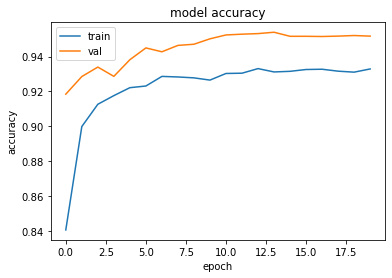

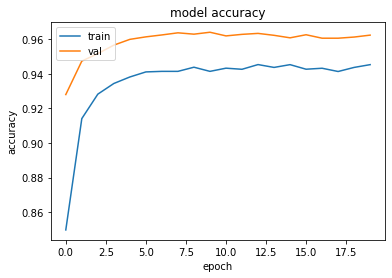

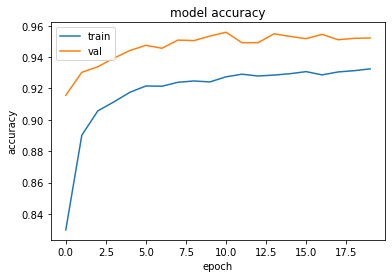

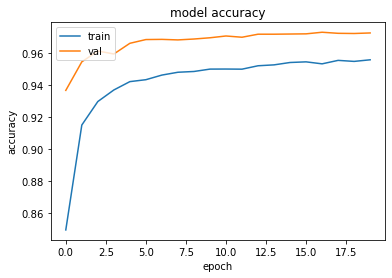

In [8]:
unigram_binary_model.plot_training_curve()
bigram_binary_model.plot_training_curve()
bigram_count_model.plot_training_curve()
tf_idf_model.plot_training_curve()

In [9]:
unigram_binary_model.get_test_accuracy()
bigram_binary_model.get_test_accuracy()
bigram_count_model.get_test_accuracy()
tf_idf_model.get_test_accuracy()

782/782 [==============================] - 9s 12ms/step - loss: 0.3619 - accuracy: 0.8740
Test acc: 0.874
782/782 [==============================] - 13s 17ms/step - loss: 0.3682 - accuracy: 0.8850
Test acc: 0.885
782/782 [==============================] - 13s 17ms/step - loss: 0.3847 - accuracy: 0.8803
Test acc: 0.880
782/782 [==============================] - 362s 463ms/step - loss: 0.3943 - accuracy: 0.8868
Test acc: 0.887


In [29]:
models = {
    "unigram_binary_model": unigram_binary_model,
    "bigram_binary_model": bigram_binary_model,
    "bigram_count_model": bigram_count_model,
    "tf_idf_model": tf_idf_model
}

In [49]:
def predict_models(models, text, is_in_tensor: bool):
    print(colored(text, 'green'))
    for items in models.items():
        model_name = items[0]
        model = items[1]
        if not is_in_tensor:
            predictions = model.forward(convert_to_tensor(text))
        else: 
            predictions = model.forward(text)
        
        print(f"{model_name}: ", colored(f"{float(predictions[0] * 100):.2f}", 'red') + " percent positive" )

In [50]:
positive_text = "That was an excellent movie, I loved it."
negative_text = "That was a bad movie, I hated it."
middle1_text = "That was a bad movie, I loved it."
middle2_text = "That was an excellent movie, I hated it."
minh_text = "I hated it. That was a sad movie."

sentences = [positive_text, negative_text, middle1_text, middle2_text, minh_text]

In [51]:
def convert_to_tensor(text):
    return tf.convert_to_tensor([[text],])

In [52]:
for sentence in sentences:
    predict_models(models, sentence, False)
    print("- - - - - - - -  - - - - - - - - - ")

That was an excellent movie, I loved it.
unigram_binary_model:  87.08 percent positive
bigram_binary_model:  94.38 percent positive
bigram_count_model:  98.69 percent positive
tf_idf_model:  99.58 percent positive
- - - - - - - -  - - - - - - - - - 
That was a bad movie, I hated it.
unigram_binary_model:  24.71 percent positive
bigram_binary_model:  5.50 percent positive
bigram_count_model:  6.42 percent positive
tf_idf_model:  3.53 percent positive
- - - - - - - -  - - - - - - - - - 
That was a bad movie, I loved it.
unigram_binary_model:  61.93 percent positive
bigram_binary_model:  44.36 percent positive
bigram_count_model:  51.02 percent positive
tf_idf_model:  57.92 percent positive
- - - - - - - -  - - - - - - - - - 
That was an excellent movie, I hated it.
unigram_binary_model:  75.93 percent positive
bigram_binary_model:  80.08 percent positive
bigram_count_model:  85.40 percent positive
tf_idf_model:  87.42 percent positive
- - - - - - - -  - - - - - - - - - 
I hated it. That 